# EXERCISE 2 b

Time for sparse solver: 0.5869 seconds


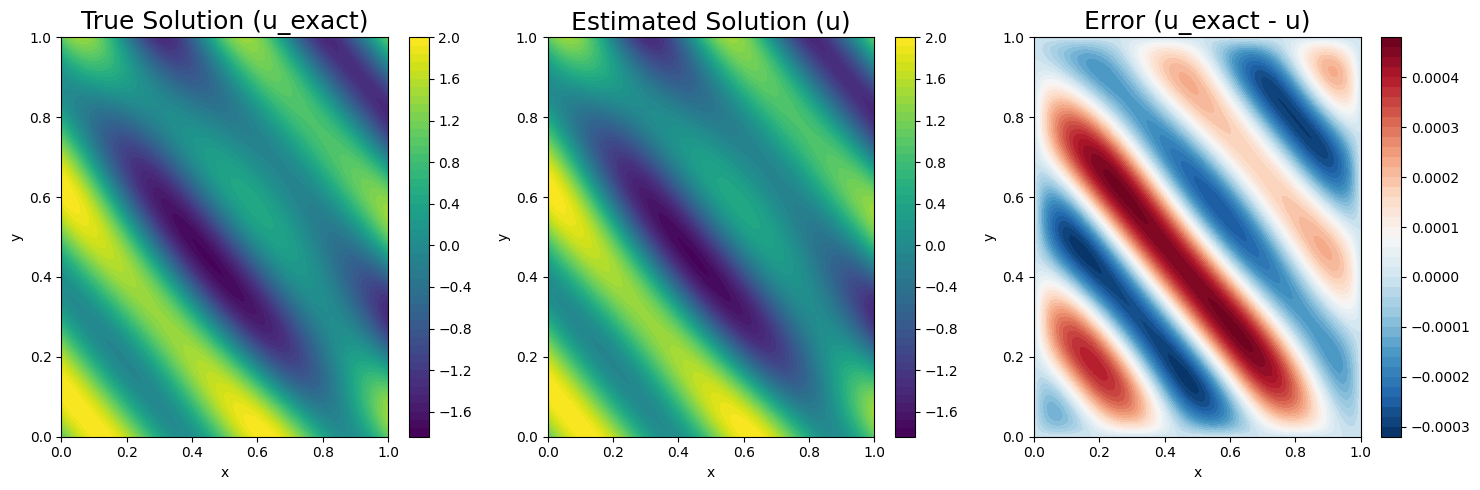

In [9]:
import numpy as np
import scipy.sparse as sp
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import time  # Import time module to measure execution time

# Solution function u(x,y)
def u_exact(x, y):
    return np.sin(4 * np.pi * (x + y)) + np.cos(4 * np.pi * x * y)

# Right-hand side function f(x,y)
def f_rhs(x, y):
    return -16 * np.pi**2 * (2 * np.sin(4 * np.pi * (x + y)) + np.cos(4 * np.pi * x * y) * (x**2 + y**2))

def plot_Laplacian(X, Y, u, error):
    # Plotting the results: True Solution, Estimated Solution, and Error
    plt.figure(figsize=(15, 5))
    font_size_title = 18  # Title font size
    # Plot the true solution (u_exact)
    plt.subplot(1, 3, 1)
    plt.title("True Solution (u_exact)", fontsize=font_size_title)
    cp1 = plt.contourf(X, Y, u_exact(X, Y), levels=50, cmap='viridis')
    cbar1 = plt.colorbar(cp1)
    plt.xlabel('x')
    plt.ylabel('y')
    # Plot the estimated solution (u)
    plt.subplot(1, 3, 2)
    plt.title("Estimated Solution (u)", fontsize=font_size_title)
    cp2 = plt.contourf(X, Y, u, levels=50, cmap='viridis')
    cbar2 = plt.colorbar(cp2)
    plt.xlabel('x')
    plt.ylabel('y')
    # Plot the error
    plt.subplot(1, 3, 3)
    plt.title("Error (u_exact - u)", fontsize=font_size_title)
    cp3 = plt.contourf(X, Y, error, levels=50, cmap='RdBu_r')
    cbar3 = plt.colorbar(cp3)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.show()
# Parameters
N = 200  # number of grid points in each direction
h = 1.0 / N  # grid spacing

# Create the grid
x_vals = np.linspace(0, 1, N+1)
y_vals = np.linspace(0, 1, N+1)

# Create 2D grid
X, Y = np.meshgrid(x_vals, y_vals, indexing="ij")

# Initialize the solution grid with boundary conditions set to the true solution
u = np.zeros((N+1, N+1))  # solution grid
u[:, 0] = u_exact(x_vals, 0)  # Left boundary
u[:, -1] = u_exact(x_vals, 1)  # Right boundary
u[0, :] = u_exact(0, y_vals)  # Bottom boundary
u[-1, :] = u_exact(1, y_vals)  # Top boundary

# Right-hand side function for interior points
f = f_rhs(X, Y)

# Poisson 5-point stencil matrix
def poisson5(m, h):
    e = np.ones(m) / h**2  # Scaling by 1/h^2 for correct discretization
    S = sp.diags([e, -2*e, e], [-1, 0, 1], shape=(m, m))
    I = sp.eye(m)
    A = sp.kron(I, S) + sp.kron(S, I)
    return A

# Laplacian kernel for convolution
L = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]]) / h**2
# right-hand side computation (convolution)
rhs = f[1:-1, 1:-1] - convolve2d(u, L, mode='valid')

# Flatten the right-hand side to a vector for the sparse solver
f_vec = rhs.flatten()

# Timing the Poisson matrix assembly
A = poisson5(N-1, h)

# Timing the sparse solver
start_time = time.time()  # Start the timer
u_inner = sp.linalg.spsolve(A, f_vec)
solver_time = time.time() - start_time  # End the timer and record the time
print(f"Time for sparse solver: {solver_time:.4f} seconds")

# Reshape the solution back into the grid (excluding boundaries)
u[1:-1, 1:-1] = u_inner.reshape((N-1, N-1))

# Now `u` contains the solution, including the boundary conditions

# Calculate the error between the exact and estimated solutions
error = u_exact(X, Y) - u

plot_Laplacian(X,Y,u,error)



Time for sparse solver: 0.9317 seconds


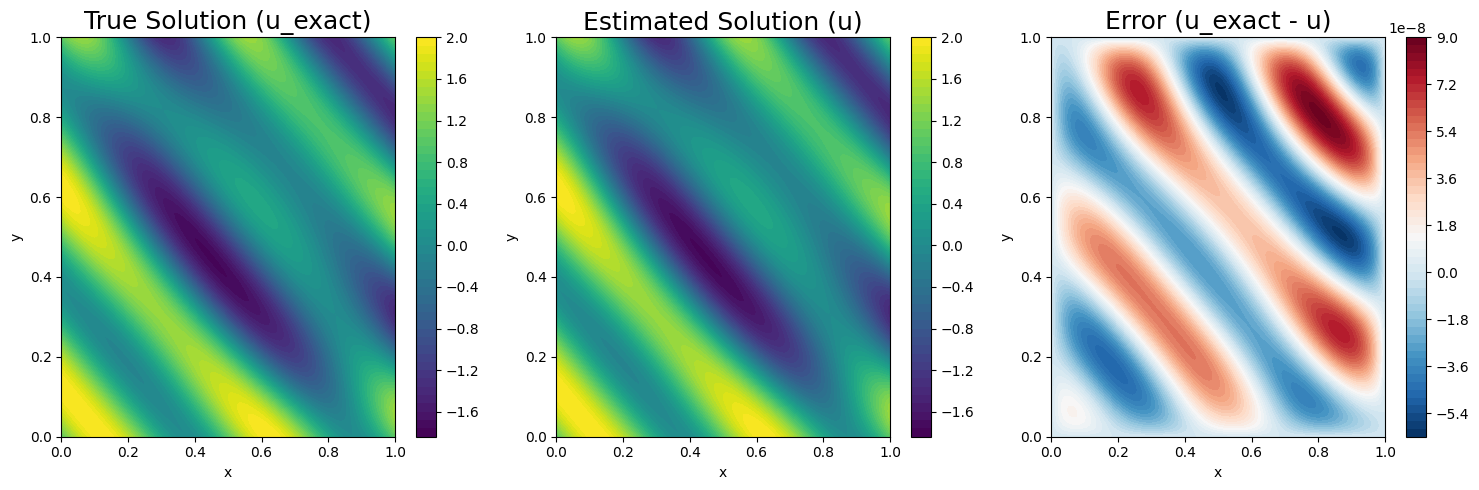

In [10]:
import numpy as np
import numpy as np
import scipy.sparse as sp
from scipy.signal import convolve2d
from scipy.sparse.linalg import cg
import matplotlib.pyplot as plt
import time  # Import time module to measure execution time

# Solution function u(x,y)
def u_exact(x, y):
    return np.sin(4 * np.pi * (x + y)) + np.cos(4 * np.pi * x * y)

# Right-hand side function f(x,y)
def f_rhs(x, y):
    return -16 * np.pi**2 * (2 * np.sin(4 * np.pi * (x + y)) + np.cos(4 * np.pi * x * y) * (x**2 + y**2))

def poisson9(m, h):
    """
    Constructs the sparse matrix A for the 9-point stencil discretization 
    using Kronecker products, equivalent to the MATLAB version.

    Parameters:
    m : int  - Number of interior grid points in one dimension

    Returns:
    A : scipy.sparse matrix (size m^2 x m^2)
    """
    e = np.ones(m)
    # Define the S matrix (tridiagonal with [-1, -10, -1])
    S = sp.diags([-e, -10*e, -e], [-1, 0, 1], shape=(m, m))
    # Define the I matrix (tridiagonal with [-1/2, 1, -1/2])
    I = sp.diags([-0.5*e, e, -0.5*e], [-1, 0, 1], shape=(m, m))
    # Compute the Kronecker sum
    A = (sp.kron(I, S) + sp.kron(S, I)) / (6 * h**2) 

    return A.tocsr()  # Convert to CSR format for efficiency

N = 200
# Parameters
N = 200  # number of grid points in each direction
h = 1.0 / N  # grid spacing

# Create the grid
x_vals = np.linspace(0, 1, N+1)
y_vals = np.linspace(0, 1, N+1)

# Initialize the solution grid with boundary conditions set to the true solution
u = np.zeros((N+1, N+1))  # solution grid
u[:, 0] = u_exact(x_vals, 0)  # Left boundary
u[:, -1] = u_exact(x_vals, 1)  # Right boundary
u[0, :] = u_exact(0, y_vals)  # Bottom boundary
u[-1, :] = u_exact(1, y_vals)  # Top boundary

# Right-hand side function for interior points
f = f_rhs(X, Y)

# Laplacian kernel for convolution
L_5 = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]]) / h**2
L_9 = np.array([[1, 4, 1], [4, -20, 4], [1, 4, 1]])/ (6 * h**2)
# right-hand side computation (convolution)
rhs = f[1:-1, 1:-1] - convolve2d(u, L_9, mode='valid') + h**2/12 * convolve2d(f, L_5, mode='valid')

# Flatten the right-hand side to a vector for the sparse solver
f_vec = rhs.flatten()

# Timing the Poisson matrix assembly
A = poisson9(N-1, h)

# Timing the sparse solver
start_time = time.time()  # Start the timer
u_inner = sp.linalg.spsolve(A, f_vec)
solver_time = time.time() - start_time  # End the timer and record the time
print(f"Time for sparse solver: {solver_time:.4f} seconds")

# Reshape the solution back into the grid (excluding boundaries)
u[1:-1, 1:-1] = u_inner.reshape((N-1, N-1))

# Now `u` contains the solution, including the boundary conditions

# Calculate the error between the exact and estimated solutions
error = u_exact(X, Y) - u


plot_Laplacian(X,Y,u,error)


 _____ N = 100 _____ 
Time for 5-point Laplacian sparse solver: 0.0648 seconds
Time for 9-point Laplacian sparse solver: 0.1288 seconds
 _____ N = 200 _____ 
Time for 5-point Laplacian sparse solver: 0.6769 seconds
Time for 9-point Laplacian sparse solver: 0.9795 seconds
 _____ N = 300 _____ 
Time for 5-point Laplacian sparse solver: 2.0530 seconds
Time for 9-point Laplacian sparse solver: 3.2142 seconds
 _____ N = 400 _____ 
Time for 5-point Laplacian sparse solver: 5.3096 seconds
Time for 9-point Laplacian sparse solver: 7.6689 seconds
 _____ N = 500 _____ 
Time for 5-point Laplacian sparse solver: 9.9506 seconds
Time for 9-point Laplacian sparse solver: 14.1774 seconds


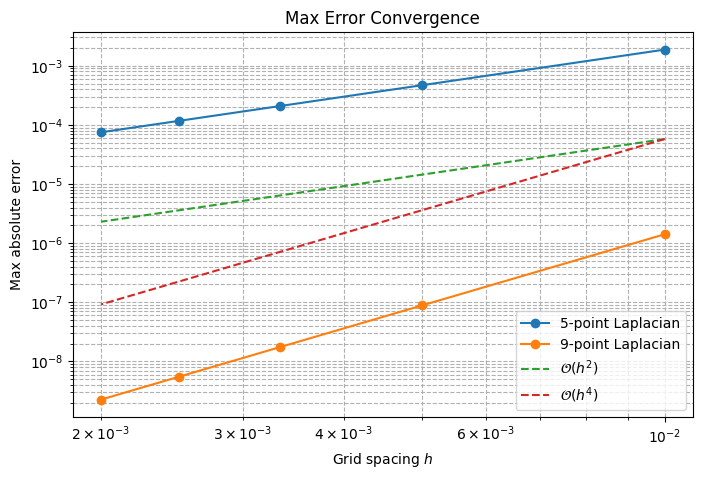

In [11]:
import numpy as np
import scipy.sparse as sp
from scipy.signal import convolve2d
from scipy.sparse.linalg import cg
import matplotlib.pyplot as plt
import time  # Import time module to measure execution time

# Solution function u(x,y)
def u_exact(x, y):
    return np.sin(4 * np.pi * (x + y)) + np.cos(4 * np.pi * x * y)

# Right-hand side function f(x,y)
def f_rhs(x, y):
    return -16 * np.pi**2 * (2 * np.sin(4 * np.pi * (x + y)) + np.cos(4 * np.pi * x * y) * (x**2 + y**2))

# Poisson 5-point stencil matrix
def poisson5(m, h):
    e = np.ones(m) / h**2  
    S = sp.diags([e, -2*e, e], [-1, 0, 1], shape=(m, m))
    I = sp.eye(m)
    A = sp.kron(I, S) + sp.kron(S, I)
    return A # Convert to CSR format for efficiency

def poisson9(m, h):
    e = np.ones(m)
    S = sp.diags([-e, -10*e, -e], [-1, 0, 1], shape=(m, m))
    I = sp.diags([-0.5*e, e, -0.5*e], [-1, 0, 1], shape=(m, m))
    A = (sp.kron(I, S) + sp.kron(S, I)) / (6 * h**2) 

    return A.tocsr()  # Convert to CSR format for efficiency

def solve_possion_5(N):

    h = 1.0 / N  # grid spacing
    
    # Create the grid
    x_vals = np.linspace(0, 1, N+1)
    y_vals = np.linspace(0, 1, N+1)

    # Create 2D grid
    X, Y = np.meshgrid(x_vals, y_vals, indexing="ij")

    # Initialize the solution grid with boundary conditions set to the true solution
    u = np.zeros((N+1, N+1))  # solution grid
    u[:, 0] = u_exact(x_vals, 0)  # Left boundary
    u[:, -1] = u_exact(x_vals, 1)  # Right boundary
    u[0, :] = u_exact(0, y_vals)  # Bottom boundary
    u[-1, :] = u_exact(1, y_vals)  # Top boundary

    # Right-hand side function for interior points
    f = f_rhs(X, Y)

    # Laplacian kernel for convolution
    L = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]]) / h**2
    # right-hand side computation (convolution)
    rhs = f[1:-1, 1:-1] - convolve2d(u, L, mode='valid')

    # Flatten the right-hand side to a vector for the sparse solver
    f_vec = rhs.flatten()

    # Timing the Poisson matrix assembly
    A = poisson5(N-1, h)

    # Timing the sparse solver
    start_time = time.time()  # Start the timer
    u_inner = sp.linalg.spsolve(A, f_vec)
    solver_time = time.time() - start_time  # End the timer and record the time
    print(f"Time for 5-point Laplacian sparse solver: {solver_time:.4f} seconds")

    # Reshape the solution back into the grid (excluding boundaries)
    u[1:-1, 1:-1] = u_inner.reshape((N-1, N-1))

    # Now `u` contains the solution, including the boundary conditions

    # Calculate the error between the exact and estimated solutions
    error = u_exact(X, Y) - u

    return np.max(np.abs(error))


def solve_possion_9(N):
    h = 1.0 / N  # grid spacing

    # Create the grid
    x_vals = np.linspace(0, 1, N+1)
    y_vals = np.linspace(0, 1, N+1)

    # Create 2D grid
    X, Y = np.meshgrid(x_vals, y_vals, indexing="ij")

    # Initialize the solution grid with boundary conditions set to the true solution
    u = np.zeros((N+1, N+1))  # solution grid
    u[:, 0] = u_exact(x_vals, 0)  # Left boundary
    u[:, -1] = u_exact(x_vals, 1)  # Right boundary
    u[0, :] = u_exact(0, y_vals)  # Bottom boundary
    u[-1, :] = u_exact(1, y_vals)  # Top boundary

    # Right-hand side function for interior points
    f = f_rhs(X, Y)

    # Laplacian kernel for convolution
    L_5 = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]]) / h**2
    L_9 = np.array([[1, 4, 1], [4, -20, 4], [1, 4, 1]])/ (6 * h**2)
    # right-hand side computation (convolution)
    rhs = f[1:-1, 1:-1] - convolve2d(u, L_9, mode='valid') + h**2/12 * convolve2d(f, L_5, mode='valid')

    # Flatten the right-hand side to a vector for the sparse solver
    f_vec = rhs.flatten()

    # Timing the Poisson matrix assembly
    A = poisson9(N-1, h)

    # Timing the sparse solver
    start_time = time.time()  # Start the timer
    u_inner = sp.linalg.spsolve(A, f_vec)
    solver_time = time.time() - start_time  # End the timer and record the time
    print(f"Time for 9-point Laplacian sparse solver: {solver_time:.4f} seconds")

    # Reshape the solution back into the grid (excluding boundaries)
    u[1:-1, 1:-1] = u_inner.reshape((N-1, N-1))

    # Now `u` contains the solution, including the boundary conditions

    # Calculate the error between the exact and estimated solutions
    error = u_exact(X, Y) - u

    return np.max(np.abs(error))


Ns = [i * 100 for i in range(1,6)]
E_5 = []
E_9 = []
for N in Ns:
    print(f' _____ N = {N} _____ ')
    E_5.append(solve_possion_5(N))
    E_9.append(solve_possion_9(N))

# Plot convergence
plt.figure(figsize=(8, 5))

# Compute h values
h_vals = 1 / np.array(Ns)  # Since h = 1/N
# Plot error
plt.loglog(h_vals, E_5, 'o-', label="5-point Laplacian")
plt.loglog(h_vals, E_9, 'o-', label="9-point Laplacian")

h_squared = h_vals ** 2  # O(h^2) scaling
# Scale reference line to match the first error value
scale_factor = (3*E_5[0]/100 + 98*E_9[0]/100) / h_squared[0]
ref_line = scale_factor * h_squared  # Adjusted O(h^2) line
# Plot O(h^2) reference line
plt.loglog(h_vals, ref_line, '--', label=r'$\mathcal{O}(h^2)$')

h_4th = h_vals ** 4  # O(h^4) scaling
# Scale reference line to match the first error value
scale_factor = (3*E_5[0]/100 + 98*E_9[0]/100) / h_4th[0]
ref_line = scale_factor * h_4th  # Adjusted O(h^2) line
# Plot O(h^2) reference line
plt.loglog(h_vals, ref_line, '--', label=r'$\mathcal{O}(h^4)$')

# Labels and title
plt.xlabel("Grid spacing $h$")
plt.ylabel("Max absolute error")
plt.title("Max Error Convergence")
plt.grid(True, which="both", linestyle="--")
plt.legend()
plt.show()


# Matrix Free CG

893


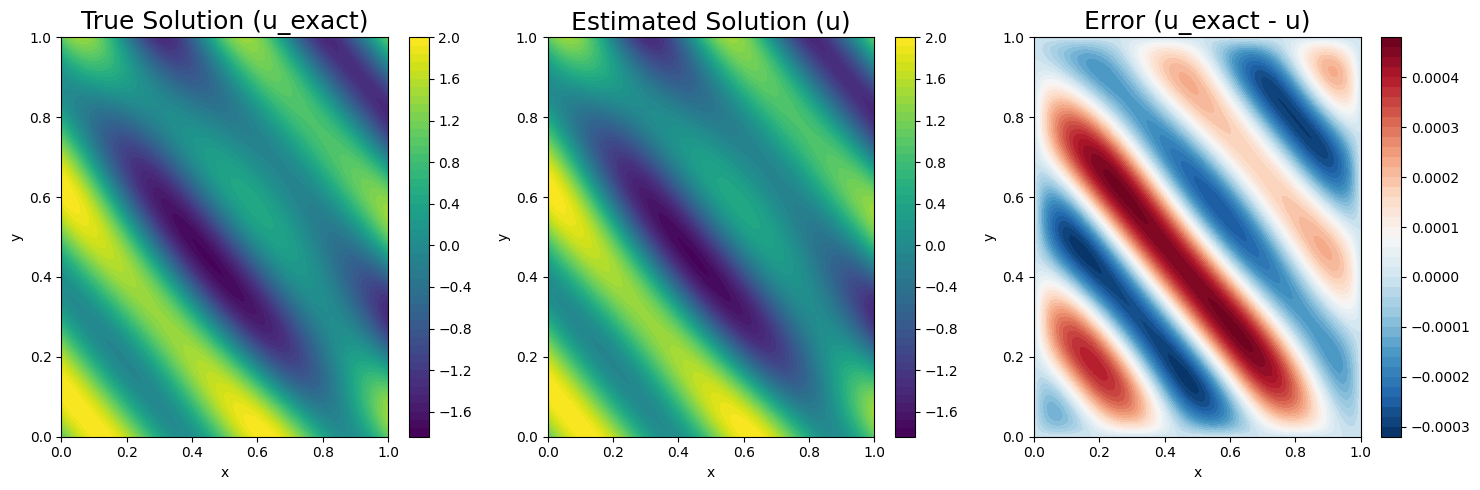

In [12]:
import numpy as np
from scipy.signal import convolve2d

def Amult(u, m):
    if len(u) != m**2:
        raise ValueError("Length of input u must be equal to m^2.")
    
    u = u.reshape(m, m)  # Reshape to 2D
    L_5 = np.array([[0, 1, 0],  
                    [1, -4, 1],
                    [0, 1, 0]]) * ((m+1)**2)  # Proper scaling of the Laplacian
    
    u = convolve2d(u, L_5, mode='same')  # Apply convolution
    return -u.reshape(m**2)  # Return as a flat vector

def cg(u_0, f, m, max_iter=10000, tol=1e-12):
    u = u_0.copy()  # Initialize solution
    r = -f - Amult(u, m)  # Initial residual
    p = r.copy()
    max_residuals = [np.max(np.abs(r))] # Initailize list for residual history
    for i in range(max_iter):
        w = Amult(p, m)
        r_dot_r = np.dot(r, r)
        a = r_dot_r / np.dot(p, w)
        
        u += a * p  # Corrected update
        r -= a * w  # Update residual
        max_residuals.append((np.max(np.abs(r)))) # append residual to history
        if np.max(np.abs(r)) < tol:
            break
        
        b = np.dot(r, r) / r_dot_r
        p = r + b * p
    print(i)
    return u, max_residuals

# Solution function u(x,y)
def u_exact(x, y):
    return np.sin(4 * np.pi * (x + y)) + np.cos(4 * np.pi * x * y)

# Right-hand side function f(x,y)
def f_rhs(x, y):
    return -16 * np.pi**2 * (2 * np.sin(4 * np.pi * (x + y)) + np.cos(4 * np.pi * x * y) * (x**2 + y**2))

N = 200
h = 1.0 / N  # grid spacing
    
# Create the grid
x_vals = np.linspace(0, 1, N+1)
y_vals = np.linspace(0, 1, N+1)

# Create 2D grid
X, Y = np.meshgrid(x_vals, y_vals, indexing="ij")

# Initialize the solution grid with boundary conditions set to the true solution
u = np.zeros((N+1, N+1))  # solution grid
u[:, 0] = u_exact(x_vals, 0)  # Left boundary
u[:, -1] = u_exact(x_vals, 1)  # Right boundary
u[0, :] = u_exact(0, y_vals)  # Bottom boundary
u[-1, :] = u_exact(1, y_vals)  # Top boundary

# Right-hand side function for interior points
f = f_rhs(X, Y)

# Laplacian kernel for convolution
L = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]]) * N**2
# right-hand side computation (convolution)
f = f[1:-1, 1:-1] - convolve2d(u, L, mode='valid')

# Flatten the right-hand side to a vector for the sparse solver
f = f.flatten()
u0 = np.zeros_like(f)

u_inner, residuals = cg(u0, f, m = N-1)
u[1:-1, 1:-1] = u_inner.reshape((N-1, N-1))
# Calculate the error between the exact and estimated solutions
error = u_exact(X, Y) - u

plot_Laplacian(X,Y,u,error)

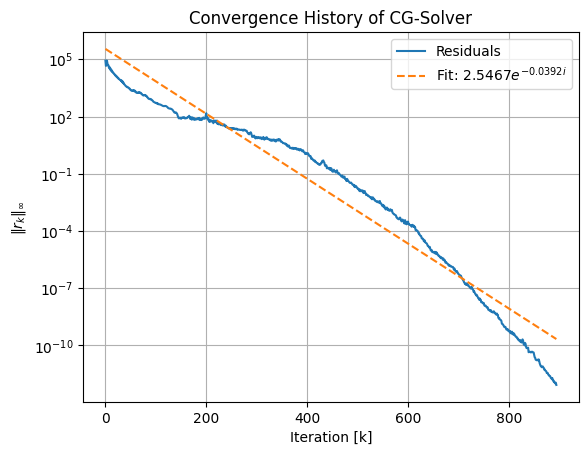

Estimated convergence rate: -0.0392


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Generate sample data (replace with your actual residuals)
# residuals = np.array([...])  # Your actual residual history

iterations = np.arange(len(residuals))  # Iteration numbers
log_residuals = np.log(residuals)  # Log of residuals

# Perform linear regression to estimate convergence rate
slope, intercept, _, _, _ = linregress(iterations, log_residuals)


# Plot the residuals and estimated convergence rate
plt.figure()
plt.semilogy(residuals, label="Residuals")
plt.semilogy(np.exp(intercept) * np.exp(slope * iterations), '--', label=f"Fit: ${np.log(intercept):.4f}e^{{{slope:.4f} i}}$")
plt.ylabel(r'$\|r_k\|_\infty$')
plt.xlabel('Iteration [k]')
plt.title('Convergence History of CG-Solver')
plt.legend()
plt.grid()
plt.show()

print(f"Estimated convergence rate: {slope:.4f}")